In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from collections import OrderedDict
import json

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fsps
# !pip install pydoe2


In [4]:
# deprecated in favour of latin hypercube

# def get_random_params(free_args):
#     params = {}
#     for param in free_args:
#         params[param] = np.random.uniform(low=free_args[param][0], high=free_args[param][1])
#     return params

## Create FSPS object with desired fixed parameters (matching our current model)

In [5]:
vactoair_flag = False
compute_vega_mags = False

zcontinuous=1  # interpolate internally to logzsol metallicity


fixed_args = OrderedDict({
    'logzsol': 0.0, 
    'sfh': 4,
    'imf_type': 2, 
    'dust_type': 2, 
    'add_dust_emission': True, 
    'duste_umin': 1.0,
    'duste_qpah': 4.0, 
    'duste_gamma': 0.001, 
    'add_igm_absorption': True, 
    'igm_factor': 1.0 
})


ssp = fsps.StellarPopulation(
    compute_vega_mags=compute_vega_mags,
    zcontinuous=zcontinuous,
    vactoair_flag=vactoair_flag,
    **fixed_args
)


### Define free FSPS parameters, with limits. 
Samples will be uniform-ish within these limits.

In [6]:
# zred only affects magnitudes within FSPS


free_args = OrderedDict({
    'tau': [0.1, 30.], 
    'tage': [0.001, 13.8],
    'dust2': [0., 2.]
})



### Make a unit hypercube and scale each dimension to match the desired limits

In [ ]:
from agnfinder import simulation_utils

In [7]:
n_samples = 150

# normalised_theta_to_sample = np.array(lhsmdu.sample(len(free_args.keys()), n_samples))
normalised_theta_to_sample = get_unit_latin_hypercube(dims=len(free_args.keys()), samples=n_samples)

theta_to_sample = simulation_utils.denormalise_hypercube(normalised_theta_to_sample, free_args)

In [8]:
theta_to_sample.shape

(150, 3)

Text(0, 0.5, 'tage')

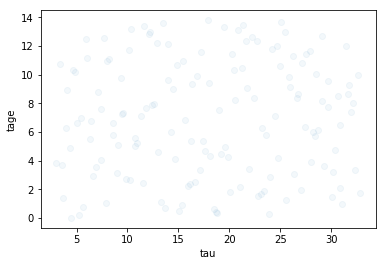

In [9]:
plt.scatter(theta_to_sample[:, 0], theta_to_sample[:, 1], alpha=0.05)
plt.xlabel('tau')
plt.ylabel('tage')

In [10]:
theta_df = pd.DataFrame(theta_to_sample, columns=free_args.keys())

In [11]:
theta_df.sample(5)

,tau,tage,dust2
91,10.243852,2.621103,0.484074
98,23.168826,6.284661,0.332596
136,16.383180,9.364019,0.653431
74,4.870441,10.187101,1.452056
62,12.179517,12.962803,0.513892


Note that FSPS seems to not remain linear in N as N increases - this motivates our emulation. 5000 samples are seconds, 50,000 fails! 

In [26]:
reference_wave_loc = '/home/mike/repos/agnfinder/notebooks/reference_wave.txt'

In [27]:
if os.path.isfile(reference_wave_loc):
    reference_wave = np.loadtxt(reference_wave_loc)
else:
    reference_wave = None

In [29]:
X = np.zeros((n_samples, len(free_args.keys())))
Y = np.zeros((n_samples, 5994))  # standard wavelengths from FSPS
mass = np.zeros(n_samples)
for n, theta_tuple in enumerate(theta_df.sample(n_samples).itertuples(name='theta')):
    
    # store X
    X[n] = [getattr(theta_tuple, p) for p in free_args.keys()]
    
    # calculate Y
    for param in free_args.keys():
        ssp.params[param] = getattr(theta_tuple, param)
    wave, spec = ssp.get_spectrum(peraa=False, tage=theta_tuple.tage)  # triggers cache
    mass[n] = ssp.stellar_mass
    if reference_wave is not None:
        assert (wave == reference_wave).all()
    
    # store Y
    Y[n] = spec
#     plt.loglog(wave, spec)
#     plt.ylim([1e-25, 1e-9])

In [22]:
X[63, :]

array([16.58213868,  2.5132542 ,  0.29598914])

In [23]:
Y[63, :]

array([1.00000000e-70, 1.00000000e-70, 1.00000000e-70, ...,
       1.85858068e-17, 1.80936924e-17, 1.76249534e-17])

In [24]:
mass[63]

0.7133454194050687

In [25]:
reference_wave = wave
np.savetxt(reference_wave_loc, reference_wave)

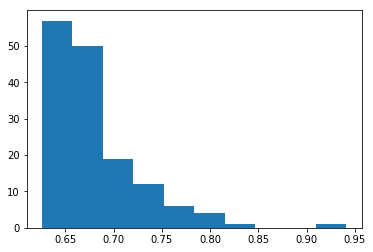

In [16]:
_ = plt.hist(mass)

In [17]:
assert False

AssertionError: 

In [ ]:
save_loc = '/home/mike/repos/agnfinder/data/fsps_cache.hdf5'
with h5py.File(save_loc, 'w') as f:
    grp = f.create_group('fsps_cache')
    ds_x = grp.create_dataset('X', data=X)
    ds_x.attrs['columns'] = list(free_args.keys())
    ds_x.attrs['limits'] = list(free_args.values())
    ds_x.attrs['description'] = 'FSPS free arguments used to generate spectra'
    ds_x.attrs['free_args'] = json.dumps(dict(free_args.items()))
    ds_x.attrs['fixed_args'] = json.dumps(dict(fixed_args.items()))
    ds_y = grp.create_dataset('Y', data=Y)
    ds_y.attrs['wavelengths'] = wave
    ds_mass = grp.create_dataset('mass', data=mass)

In [ ]:
with h5py.File(save_loc, 'r') as f:
    X_loaded = f['fsps_cache']['X'][...]
    Y_loaded = f['fsps_cache']['Y'] [...]

In [ ]:
assert np.allclose(X_loaded, X)
assert np.allclose(Y_loaded, Y)

In [ ]:
assert False  # old stuff below

In [ ]:
%%timeit

ssp.get_spectrum(tage=0.5, peraa=False)

In [ ]:
%%timeit

ssp.get_spectrum(tage=1.5, peraa=False)

In [ ]:
wave, flux = ssp.get_spectrum(tage=2.5, peraa=False)

In [ ]:
plt.loglog(wave, flux)

In [ ]:
# ssp = fsps.StellarPopulation(
#     compute_vega_mags=compute_vega_mags,
#     zcontinuous=zcontinuous,
#     vactoair_flag=vactoair_flag,
#     tau=2.
# )

# wave, spec = ssp.get_spectrum(tage=tage, peraa=False)  # triggers cache

In [ ]:
# plt.loglog(wave, flux)

In [ ]:
ssp.params

In [ ]:
ssp.params['tau'] = 1.5

In [ ]:
ssp.params['tau']

In [ ]:
wave, spec = ssp.get_spectrum(tage=tage, peraa=False)

In [ ]:
for tau in np.linspace(0., 10., 20):
    ssp.tau = tau
    wave, flux = ssp.get_spectrum(tage=tage, peraa=False)
    plt.loglog(wave, flux, label=tau)
plt.legend()

In [ ]:
ssp.params['logzsol'] = -1
wave, flux = ssp.get_spectrum(tage=tage, peraa=False)
plt.loglog(wave, flux)

In [ ]:
# ssp.params['tau'] = 5.
ssp.params['logzsol'] = -2.
wave, flux = ssp.get_spectrum(tage=tage, peraa=False)
plt.loglog(wave, flux)

In [ ]:
ssp.params['tau'] = 5.
wave, flux = ssp.get_spectrum(tage=tage, peraa=False)
plt.loglog(wave, flux)

In [ ]:
for tau in np.linspace(0., 10., 20):
    ssp.params['logzsol'] = -1
    wave, flux = ssp.get_spectrum(tage=tage, peraa=False)
    plt.loglog(np.range(len()))
plt.legend()

In [ ]:
for tage in np.linspace(0.1, 2.):
    wave, flux = ssp.get_spectrum(tage=tage, peraa=False)
    plt.loglog(wave, flux, label=tage)
plt.legend()

In [ ]:
ssp.params.dirtiness

In [ ]:
ssp.params['tau'] = 2.5
ssp.params['dust2'] = 0.5
ssp.params['tage'] = 7

In [ ]:
ssp.params.dirtiness

In [ ]:
wave, flux = ssp.get_spectrum(tage=tage, peraa=False)

In [ ]:
ssp.params.dirtiness

In [ ]:
# dust2 and tage are CSP parameters

In [ ]:
plt.loglog(wave, flux, label=tau)